In [35]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

### Data Loading

In [36]:
def load_data(train_split, val_split, verbose=False):
    # Get features (X) and targets (y) from the California housing dataset
    X, y = fetch_california_housing(return_X_y=True)

    # Use np.random.permutation to shuffle indices
    indices = np.random.permutation(len(X))

    # Use the same shuffled indices for both features and targets to maintain alignment
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # check if data is actually shuffled
    assert not np.array_equal(X_shuffled[0], X[0])

    # Calculate split sizes
    num_samples = len(X)
    num_train = int(num_samples * train_split)
    num_val = int(num_samples * val_split)

    # Split the data into train, validation, and test sets
    X_train = X_shuffled[:num_train]
    y_train = y_shuffled[:num_train]

    X_val = X_shuffled[num_train : num_train + num_val]
    y_val = y_shuffled[num_train : num_train + num_val]

    X_test = X_shuffled[num_train + num_val :]
    y_test = y_shuffled[num_train + num_val :]

    # Compute normalization parameters from training data only
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    y_train_mean = np.mean(y_train)
    y_train_std = np.std(y_train)

    # Normalize all sets using training set statistics
    X_train_normed = (X_train - X_train_mean) / X_train_std
    X_val_normed = (X_val - X_train_mean) / X_train_std
    X_test_normed = (X_test - X_train_mean) / X_train_std

    y_train_normed = (y_train - y_train_mean) / y_train_std
    y_val_normed = (y_val - y_train_mean) / y_train_std
    y_test_normed = (y_test - y_train_mean) / y_train_std

    if verbose:
        print(f"Train set size: {len(X_train)}")
        print(f"Validation set size: {len(X_val)}")
        print(f"Test set size: {len(X_test)}")

    return (
        list(zip(X_train_normed, y_train_normed)),
        list(zip(X_val_normed, y_val_normed)),
        list(zip(X_test_normed, y_test_normed)),
    )



### Manual implementation - not vectorised


In [37]:
def evaluate_model_manual(weights, bias, test_set):
    running_loss = 0.0
    # Iterate over each data point in the test set
    for x, y in test_set:
        y_pred = 0.0
        # Calculate prediction using weights and bias
        for i in range(len(weights)):
            y_pred += weights[i] * x[i]
        y_pred = y_pred + bias
        # Calculate loss for this data point
        loss = (y_pred - y) ** 2
        running_loss += loss

    # Calculate normalised loss by dividing by the number of data points
    normalised_loss = running_loss / len(test_set)
    return normalised_loss

def train_manual(train_set, val_set, epochs, lr, weights=None, bias=1, verbose=False):
    n_params = len(train_set[0][0])

    # init weights and bias if not provided
    if weights is None:
        weights = np.random.uniform(-1, 1, n_params)
    if bias is None:
        bias = 1

    train_loss_list = []
    val_loss_list = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for x, y in train_set:
            # make linear prediction
            y_pred = 0.0
            for i in range(n_params):
                y_pred += weights[i] * x[i]

            y_pred = y_pred + bias

            # calculate MSE
            loss = (y_pred - y) ** 2
            running_loss += loss

            # calculate grad of loss
            loss_grad = 2 * (y_pred - y)

            # update weights
            for i in range(n_params):
                weight_grad = x[i] * loss_grad
                weights[i] = weights[i] - lr * weight_grad

            # update bias
            bias_grad = loss_grad
            bias = bias - lr * bias_grad

        normalised_loss = running_loss / len(train_set)
        train_loss_list.append(normalised_loss)

        # evaluate on validation set
        val_loss = evaluate_model_manual(weights, bias, val_set)
        val_loss_list.append(val_loss)

        if verbose:
            # make sample prediction
            x, y = train_set[0]
            y_pred = 0.0
            for i in range(n_params):
                y_pred += weights[i] * x[i]
            y_pred = y_pred + bias
            print(f"Epoch {epoch}: Prediction: {y_pred:.4f}, True Value: {y:.4f}")

    return train_loss_list, val_loss_list

### Vectorised full batch implementation


##### Model class

In [38]:
class LinearRegression:
    def __init__(self, n_params, weights=None, bias=1, lr=0.001, full_batch=False):
        self.input = None
        self.bias = bias
        self.weights = weights
        self.lr = lr
        self.full_batch = full_batch

        if weights is None:
            print("Initial weights are None, generating random weights")
            self.weights = np.random.uniform(-1, 1, n_params)

    def forward(self, x, no_grad=False):
        if not no_grad:
            self.input = x
        if self.full_batch:
            return x @ self.weights + self.bias
        else:
            # check if not also @
            return np.dot(x, self.weights) + self.bias

    def step(self, grad):
        if self.full_batch:
            grad_w = (self.input.T @ grad) / len(self.input)
            grad_b = np.mean(grad)
            self.weights = self.weights - self.lr * grad_w
            self.bias = self.bias - self.lr * grad_b
        else:
            self.weights = self.weights - self.lr * grad * self.input
            self.bias = self.bias - self.lr * grad

    def __call__(self, x, no_grad=False):
        return self.forward(x, no_grad)

##### MSE implementation

In [39]:
class MSE:
    def __init__(self, full_batch=False):
        self.y_pred = None
        self.y = None
        self.full_batch = full_batch

    def forward(self, y_pred, y, no_grad=False):
        if not no_grad:
            self.y_pred = y_pred
            self.y = y
        if self.full_batch:
            return np.mean((y_pred - y) ** 2)
        else:
            return (y_pred - y) ** 2

    def backward(self):
        if self.full_batch:
            grad = 2 * (self.y_pred - self.y) / len(self.y)
        else:
            grad = 2 * (self.y_pred - self.y)
        return grad

    def __call__(self, y_pred, y, no_grad=False):
        return self.forward(y_pred, y, no_grad)

##### Training and Evaluation functions

In [40]:
def evaluate_model_full(model, loss_fn, x_test, y_test):
    # make prediction
    y_pred = model(x_test, no_grad=True)
    # calculate loss
    loss = loss_fn(y_pred, y_test, no_grad=True)
    return loss


def train_vectorised_full_batch(
    model, loss_fn, train_set, val_set, epochs, verbose=False
):
    train_loss_list = []
    val_loss_list = []

    # convert train_set to numpy arrays to process in parallel
    x_train = np.array([item[0] for item in train_set])
    y_train = np.array([item[1] for item in train_set])

    x_val = np.array([item[0] for item in val_set])
    y_val = np.array([item[1] for item in val_set])

    for epoch in tqdm(range(epochs)):
        # make prediction
        y_pred = model(x_train)
        # calculate loss
        loss = loss_fn(y_pred, y_train)
        # get grad of loss function
        grad = loss_fn.backward()
        # update model
        model.step(grad)
        # evaluate model on validation set
        val_loss = evaluate_model_full(model, loss_fn, x_val, y_val)

        # log loss
        normalised_train_loss = loss
        train_loss_list.append(normalised_train_loss)
        normalised_val_loss = val_loss
        val_loss_list.append(normalised_val_loss)

        if verbose:
            # make sample prediction
            x, y = x_train[0], y_train[0]
            y_pred = model(x)
            print(f"Epoch {epoch}: Prediction: {y_pred:.4f}, True Value: {y:.4f}")

    return train_loss_list, val_loss_list

##### Plotting functions

In [41]:
def plot_manual_vs_vectorised_loss(train_loss_manual, train_loss_vectorised, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_manual, label="Manual Training Loss")
    plt.plot(train_loss_vectorised, label="Vectorised Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_predictions_vs_actual(test_set, weights_manual, bias_manual, model):
    x_test = np.array([item[0] for item in test_set])
    y_test = np.array([item[1] for item in test_set])

    # Manual model predictions
    manual_predictions = []
    for x in x_test:
        y_pred = 0.0
        for i in range(len(weights_manual)):
            y_pred += weights_manual[i] * x[i]
        y_pred = y_pred + bias_manual
        manual_predictions.append(y_pred)
    manual_predictions = np.array(manual_predictions)

    # Vectorised model predictions
    vectorised_predictions = model(x_test, no_grad=True)

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))

    # Sort values for better visualization
    sort_idx = np.argsort(y_test)
    y_test_sorted = y_test[sort_idx]
    manual_pred_sorted = manual_predictions[sort_idx]
    vectorised_pred_sorted = vectorised_predictions[sort_idx]

    # Plot predictions first (so they appear behind actual values)
    plt.scatter(
        range(len(manual_pred_sorted)),
        manual_pred_sorted,
        label="Manual Predictions",
        alpha=0.5,
        color="blue",
        zorder=1,
    )
    plt.scatter(
        range(len(vectorised_pred_sorted)),
        vectorised_pred_sorted,
        label="Vectorised Predictions",
        alpha=0.5,
        color="red",
        zorder=1,
    )
    plt.scatter(
        range(len(y_test_sorted)),
        y_test_sorted,
        label="Actual Values",
        alpha=0.5,
        color="black",
        zorder=2,
    )

    plt.xlabel("Sample Index (sorted by actual values)")
    plt.ylabel("Value")
    plt.title("Manual vs Vectorised Predictions on Test Set")
    plt.legend()
    plt.show()

### Main Loop

##### Config

In [42]:
# commented are the values used in the report
verbose = False
seed = 42  # 42

# data split
train_split = 0.7  # 0.7
val_split = 0.15  # 0.15

# training parameters
lr_manual = 0.0001  # 0.0001 
lr_full_batch = 500  # 500
epochs_manual = 20  # 20
epochs_full_batch = 1000  # 1000

In [43]:
# Set random seed for reproducibility
np.random.seed(seed)

# load and split data
train_set, val_set, test_set = load_data(train_split, val_split, verbose=verbose)

# init weights and bias randomly, but ensure same for both models
n_params = len(train_set[0][0])
weights_manual = np.random.uniform(-1, 1, n_params)
bias_manual = 1
weights_vectorised = weights_manual.copy()
bias_vectorised = 1

# Initialize model
model = LinearRegression(
    n_params=n_params,
    lr=lr_full_batch,
    weights=weights_vectorised,
    bias=bias_vectorised,
    full_batch=True,
)
loss_fn = MSE(full_batch=True)

print("Training manual model...")
start_time_manual = time.time()
train_loss_manual, val_loss_manual = train_manual(
    train_set,
    val_set,
    epochs_manual,
    lr_manual,
    weights_manual,
    bias_manual,
    verbose=verbose,
)
end_time_manual = time.time()
print(f"Manual model training time: {end_time_manual - start_time_manual:.4f} seconds")

print("Training vectorised model...")
start_time_vectorised = time.time()
train_loss_vectorised, val_loss_vectorised = train_vectorised_full_batch(
    model, loss_fn, train_set, val_set, epochs_full_batch, verbose=verbose
)
end_time_vectorised = time.time()
print(f"Vectorised model training time: {end_time_vectorised - start_time_vectorised:.4f} seconds")

print("Evaluating manual model...")
test_loss_manual = evaluate_model_manual(weights_manual, bias_manual, test_set)

print("Evaluating vectorised model...")
x_test = np.array([item[0] for item in test_set])
y_test = np.array([item[1] for item in test_set])
test_loss_vectorised = evaluate_model_full(model, loss_fn, x_test, y_test)

print(f"Manual training loss: {train_loss_manual[-1]:.4f}")
print(f"Manual validation loss: {val_loss_manual[-1]:.4f}")
print(f"Manual test loss: {test_loss_manual:.4f}")

print(f"Vectorised training loss: {train_loss_vectorised[-1]:.4f}")
print(f"Vectorised validation loss: {val_loss_vectorised[-1]:.4f}")
print(f"Vectorised test loss: {test_loss_vectorised:.4f}")

# print number of update steps per model
print("Manual update steps:", len(train_loss_manual) * len(train_set))
print("Vectorised update steps:", epochs_full_batch)

Training manual model...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Manual model training time: 4.2443 seconds
Training vectorised model...


100%|██████████| 1000/1000 [00:00<00:00, 2224.08it/s]

Vectorised model training time: 0.4624 seconds
Evaluating manual model...
Evaluating vectorised model...
Manual training loss: 0.3993
Manual validation loss: 0.3894
Manual test loss: 1.4007
Vectorised training loss: 0.3937
Vectorised validation loss: 0.3884
Vectorised test loss: 0.4087
Manual update steps: 288940
Vectorised update steps: 1000


#### Evaluation

##### Efficency:
It is clear that the vectorised model is a lot faster and therefor more efficent then the manual model. As can be seen by the training time:
Manual: 4.2443
Vectorised: 0.4624

Important to note is, that the vectorised version is doing fullbatch gradient decent, which means it is training on the whole train dataset in one step. Where as the manual version is training in mini batches, so evaluting and updating on each data point. This leads to different results when it comes to generalisation and requires very different hyperparameters. Which is why the learning rate of the manula model is 0.0001 and the for the vectorised model it is 500, which is order of magnitude higher.

This all becomes clearer when we look at the number of update steps for each model.
Manual: 288940
Vectorised: 1000

For the vectorised model, the number of update steps is just equivalent to the number of epochs. For the manual model on the other hand, it is the number of epochs times the number of data points in our training set. So the vectorised model needs a lot fewer steps to converge. This is hard to see in the plots provided tough, because they show the epochs. And in that comparison the manual model only needs 20 epochs, wehre as the vectorised model trains over 1000. 

##### Performance:
Full batch vs mini batch gradient decent have different effects on the speed of convergence, generlisability of the model and so on. In our case the full batch vectorised model has better test set performance then the manual mini batch model. To make this comparison more fair, one might use gradient accumulation for the manual model, or mini batching for the vectorised model. Then it would be expected that both models provide the exact same results, with different training speed. 

As can be seen in the plot below, the vectorised model has a better performance on the test set, but there is still a good deal of variance remaining.

##### Hyperparameters:
As already noted, the hyperparameters, in this case the number of epochs, learning rate, and batch size varies widely between the models. Espacially due to the nature of the batch size, the number of epochs and the learning rate is different by order of magnitude.

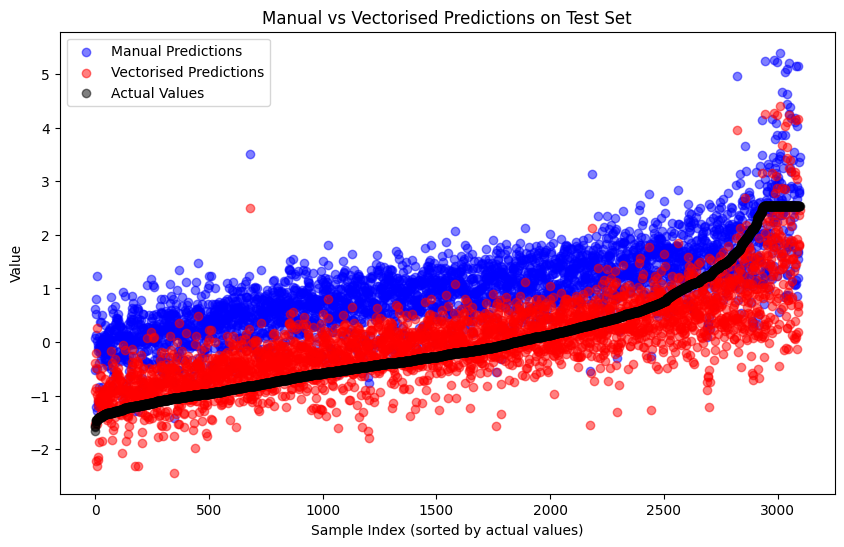

In [48]:
plot_predictions_vs_actual(test_set, weights_manual, bias_manual, model)

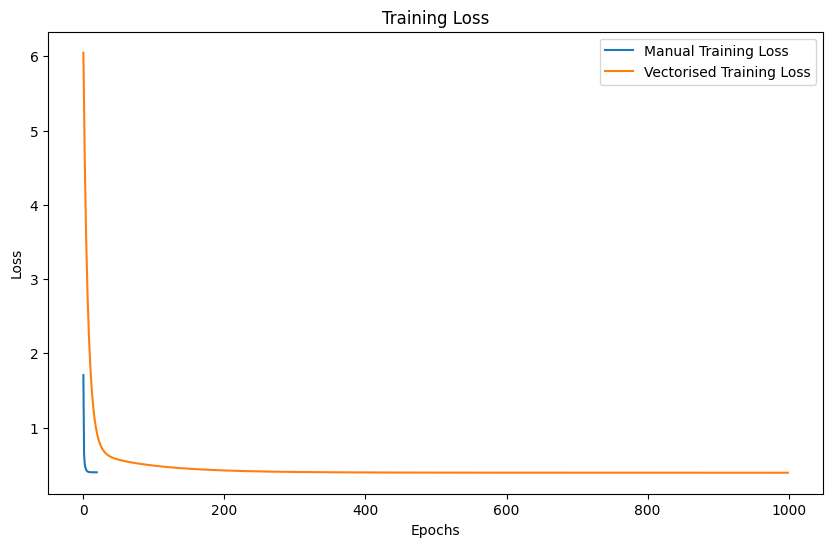

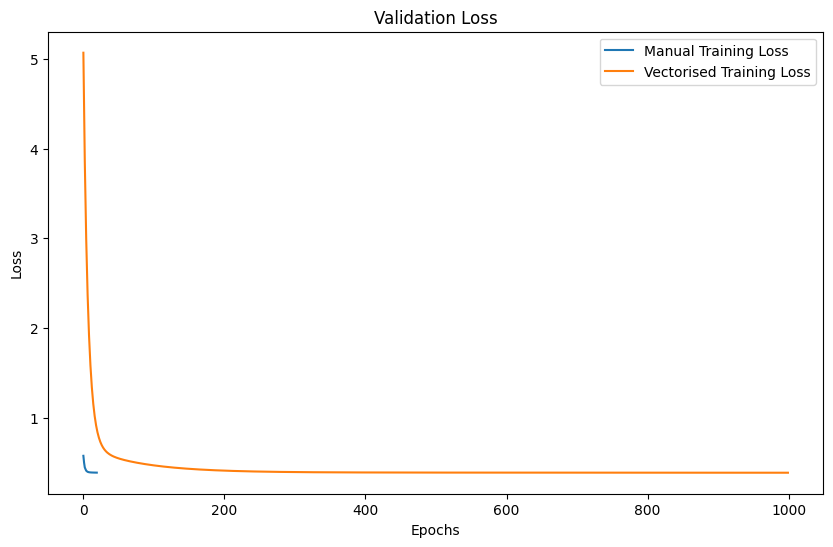

In [45]:
# Plot training and validation losses
plot_manual_vs_vectorised_loss(
    train_loss_manual, train_loss_vectorised, "Training Loss"
)
plot_manual_vs_vectorised_loss(
    val_loss_manual, val_loss_vectorised, "Validation Loss"
)